# Fake News Detection with Pytorch Geometric

## Installation

In [3]:
import torch
vers = torch.__version__
print("Torch vers: ", vers)

# PyG installation
!pip install -q torch-scatter -f https://pytorch-geometric.com/whl/torch-${TORCH}+${CUDA}.html
!pip install -q torch-sparse -f https://pytorch-geometric.com/whl/torch-${TORCH}+${CUDA}.html
!pip install -q git+https://github.com/rusty1s/pytorch_geometric.git

import torch_geometric

Torch vers:  1.11.0+cu113
     |████████████████████████████████| 48 kB 2.4 MB/s 


## Dataset

- Contains news propagation graphs extracted from Twitter with user profile data
- Source and raw data: https://github.com/KaiDMML/FakeNewsNet
- Reference: https://arxiv.org/pdf/2104.12259.pdf
- feature="content" --> Spacy Word2Vec + Profile features


In [33]:
from torch_geometric.datasets import UPFD
train_data = UPFD(root=".", name="gossipcop", feature="bert", split="train")
test_data = UPFD(root=".", name="gossipcop", feature="bert", split="test")
print("Train Samples: ", len(train_data))
print("Test Samples: ", len(test_data))

Train Samples:  1092
Test Samples:  3826


### Investigating the News Propagation Graph

In [6]:
sample_id=1
train_data[sample_id].edge_index # shows the root nodes and corresponding connected nodes

tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  15,  15,  17,  17,
          22,  22,  22,  22,  23,  26,  26,  26,  26,  26,  26,  26,  26,  27,
          27,  27,  28,  28,  28,  28,  28,  28,  28,  28,  28,  28,  28,  28,
          28,  28,  28,  28,  28,  28,  28,  28,  28,  28,  28,  28,  28,  28,
          28,  28,  28,  28,  28,  28,  28,  28,  30,  34,  34,  38,  38,  38,
          38,  39,  40,  57,  59,  65,  65,  65,  66,  68,  69,  77,  77,  79,
          79,  80,  83,  83,  83,  83,  84, 101, 110, 115, 116, 117],
        [  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,
          15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  28,
          29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  43,  44,
          45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  5

In [7]:

!pip install networkx
import networkx as nx

# From PyG utils
def to_networkx(data, node_attrs=None, edge_attrs=None, to_undirected=False,
                remove_self_loops=False):
    if to_undirected:
        G = nx.Graph()
    else:
        G = nx.DiGraph()
    G.add_nodes_from(range(data.num_nodes))
    node_attrs, edge_attrs = node_attrs or [], edge_attrs or []
    values = {}
    for key, item in data(*(node_attrs + edge_attrs)):
        if torch.is_tensor(item):
            values[key] = item.squeeze().tolist()
        else:
            values[key] = item
        if isinstance(values[key], (list, tuple)) and len(values[key]) == 1:
            values[key] = item[0]
    for i, (u, v) in enumerate(data.edge_index.t().tolist()):
        if to_undirected and v > u:
            continue
        if remove_self_loops and u == v:
            continue
        G.add_edge(u, v)
        for key in edge_attrs:
            G[u][v][key] = values[key][i]
    for key in node_attrs:
        for i, feat_dict in G.nodes(data=True):
            feat_dict.update({key: values[key][i]})
    return G

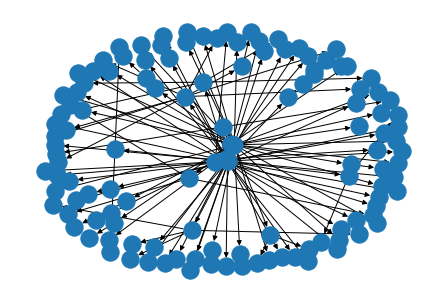

In [34]:
nx.draw(to_networkx(train_data[sample_id]))
# nx.draw(to_networkx(train_data[2]))


### Node features

In [10]:
print(train_data[sample_id].x.shape)
train_data[sample_id].x

torch.Size([125, 768])


tensor([[-0.0895, -0.0141, -0.2686,  ...,  0.1738,  0.3480,  0.1831],
        [ 0.0600,  0.0440,  0.0087,  ...,  0.4195,  0.0239,  0.5018],
        [ 0.1362, -0.0738,  0.0080,  ...,  0.3674, -0.1551,  0.3255],
        ...,
        [-0.0284,  0.2227,  0.0766,  ...,  0.5024, -0.0791,  0.7929],
        [-0.0515,  0.1556,  0.2712,  ...,  0.4764,  0.0087,  0.4305],
        [ 0.0070,  0.1475,  0.0915,  ...,  0.5039, -0.0133,  0.6324]])

### Class distribution

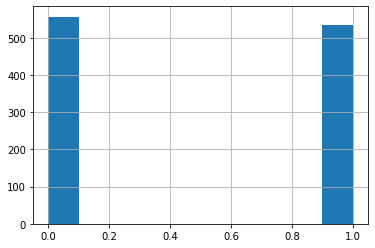

In [35]:
import pandas as pd
labels = [data.y.item() for i, data in enumerate(train_data)]
df = pd.DataFrame(labels, columns=["Labels"])
df["Labels"].hist()

### Data Loaders

In [36]:
from torch_geometric.loader import DataLoader
train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
test_loader = DataLoader(test_data, batch_size=128, shuffle=False)

## Model and Training

--> Because it is a directed graph, it will only share information from the root

In [47]:
import torch
import torch.nn.functional as F
from torch.nn import BatchNorm1d, Linear, ReLU, Sequential

from torch_geometric.nn import GINConv, global_add_pool

class GINNet(torch.nn.Module):
    def __init__(self, in_channels, dim, out_channels):
        super().__init__()
        
        self.conv1 = GINConv(
            Sequential(Linear(in_channels, dim), BatchNorm1d(dim), ReLU(),
                       Linear(dim, dim), ReLU()))

        self.conv2 = GINConv(
            Sequential(Linear(dim, dim), BatchNorm1d(dim), ReLU(),
                       Linear(dim, dim), ReLU()))

        self.conv3 = GINConv(
            Sequential(Linear(dim, dim), BatchNorm1d(dim), ReLU(),
                       Linear(dim, dim), ReLU()))

        
        self.lin_news = Linear(in_channels, dim)

        self.lin1 = Linear(dim, dim)
        self.lin2 = Linear(2*dim, out_channels)

    def forward(self, x, edge_index, batch):
        h = self.conv1(x, edge_index)
        h = self.conv2(h, edge_index)
        h = self.conv3(h, edge_index)
        
        h = global_add_pool(h, batch)
        h = self.lin1(h).relu()
        h = F.dropout(h, p=0.5, training=self.training)
        #h = self.lin2(h)
        # According to UPFD paper: Include raw word2vec embeddings of news 
        # This is done per graph in the batch
        root = (batch[1:] - batch[:-1]).nonzero(as_tuple=False).view(-1)
        root = torch.cat([root.new_zeros(1), root + 1], dim=0)
        # root is e.g. [   0,   14,   94,  171,  230,  302, ... ]
        news = x[root]
        news = self.lin_news(news).relu()
        
        out = self.lin2(torch.cat([h, news], dim=-1))
        return torch.sigmoid(out)

GINNet(train_data.num_features,64, 1)

GINNet(
  (conv1): GINConv(nn=Sequential(
    (0): Linear(in_features=768, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=64, out_features=64, bias=True)
    (4): ReLU()
  ))
  (conv2): GINConv(nn=Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=64, out_features=64, bias=True)
    (4): ReLU()
  ))
  (conv3): GINConv(nn=Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=64, out_features=64, bias=True)
    (4): ReLU()
  ))
  (lin_news): Linear(in_features=768, out_features=64, bias=True)
  (lin1): Linear(in_features=64, out_features=64, bias=True)
  (lin2): Linear(in_feat

In [48]:
from sklearn.metrics import accuracy_score, f1_score

device = torch.device('cpu')
model = GINNet(train_data.num_features,64,1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fnc = torch.nn.BCELoss()

def train(epoch):
    model.train()
    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.batch)
        loss = loss_fnc(torch.reshape(out, (-1,)), data.y.float())
        loss.backward()
        optimizer.step()
        total_loss += float(loss) * data.num_graphs
    return total_loss / len(train_loader.dataset)


@torch.no_grad()
def test(epoch):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    for data in test_loader:
        data = data.to(device)
        out = model(data.x, data.edge_index, data.batch)
        loss = loss_fnc(torch.reshape(out, (-1,)), data.y.float())
        total_loss += float(loss) * data.num_graphs
        all_preds.append(torch.reshape(out, (-1,)))
        all_labels.append(data.y.float())

    # Calculate Metrics
    accuracy, f1 = metrics(all_preds, all_labels)

    return total_loss / len(test_loader.dataset), accuracy, f1


def metrics(preds, gts):
    preds = torch.round(torch.cat(preds))
    gts = torch.cat(gts)
    acc = accuracy_score(preds, gts)
    f1 = f1_score(preds, gts)
    return acc, f1


In [49]:
for epoch in range(40):
    train_loss = train(epoch)
    test_loss, test_acc, test_f1 = test(epoch)
    print(f'Epoch: {epoch:02d} |  TrainLoss: {train_loss:.2f} | '
          f'TestLoss: {test_loss:.2f} | TestAcc: {test_acc:.2f} | TestF1: {test_f1:.2f}')

Epoch: 00 |  TrainLoss: 0.83 | TestLoss: 1.69 | TestAcc: 0.52 | TestF1: 0.67
Epoch: 01 |  TrainLoss: 0.49 | TestLoss: 1.50 | TestAcc: 0.74 | TestF1: 0.67
Epoch: 02 |  TrainLoss: 0.37 | TestLoss: 1.03 | TestAcc: 0.78 | TestF1: 0.76
Epoch: 03 |  TrainLoss: 0.34 | TestLoss: 0.46 | TestAcc: 0.83 | TestF1: 0.84
Epoch: 04 |  TrainLoss: 0.31 | TestLoss: 0.48 | TestAcc: 0.77 | TestF1: 0.80
Epoch: 05 |  TrainLoss: 0.27 | TestLoss: 0.67 | TestAcc: 0.66 | TestF1: 0.74
Epoch: 06 |  TrainLoss: 0.24 | TestLoss: 0.72 | TestAcc: 0.84 | TestF1: 0.83
Epoch: 07 |  TrainLoss: 0.21 | TestLoss: 1.01 | TestAcc: 0.82 | TestF1: 0.81
Epoch: 08 |  TrainLoss: 0.21 | TestLoss: 0.54 | TestAcc: 0.79 | TestF1: 0.82
Epoch: 09 |  TrainLoss: 0.18 | TestLoss: 0.50 | TestAcc: 0.87 | TestF1: 0.87
Epoch: 10 |  TrainLoss: 0.13 | TestLoss: 0.65 | TestAcc: 0.87 | TestF1: 0.87
Epoch: 11 |  TrainLoss: 0.10 | TestLoss: 0.54 | TestAcc: 0.85 | TestF1: 0.86
Epoch: 12 |  TrainLoss: 0.10 | TestLoss: 0.86 | TestAcc: 0.75 | TestF1: 0.80

In [50]:
for data in test_loader:
    data = data.to(device)
    pred = model(data.x, data.edge_index, data.batch)
    df = pd.DataFrame()
    df["pred_logit"] = pred.detach().numpy()[:,0]
    df["pred"] = torch.round(pred).detach().numpy()[:,0]
    df["true"] = data.y.numpy()
    print(df.head(10))
    break

     pred_logit  pred  true
0  3.379075e-01   0.0     1
1  8.064532e-01   1.0     1
2  7.080464e-09   0.0     0
3  9.833463e-01   1.0     1
4  5.164428e-05   0.0     0
5  1.689837e-10   0.0     0
6  0.000000e+00   0.0     0
7  9.918327e-01   1.0     1
8  3.717294e-11   0.0     0
9  3.545763e-03   0.0     0
